# Practical 3: Convolutional Neural Networks (CNNs)

In [1]:
import torch, os
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

"""
Configurations
"""
use_gpu = True # use GPU or CPU
dataset_path = '.'
batch_size = 64

if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '1' # select GPU if necessary
    device = 'cuda'
else:
    device = 'cpu'


mnist_transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

dataset = datasets.MNIST(root=dataset_path, train=True, download=False, transform=mnist_transform)
dataset_train, dataset_val = random_split(dataset, [50000, 10000])
dataset_test = datasets.MNIST(root=dataset_path, train=False, transform=mnist_transform)

train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

In [81]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Sequential(
            # torch.nn.Conv2d(in_channels=1, out_channels=25, kernel_size=12, stride=2),
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2),
        )
        self.conv2 = torch.nn.Sequential(
            # torch.nn.Conv2d(in_channels=25, out_channels=64, kernel_size=5, stride=1),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2),
            # torch.nn.MaxPool2d(kernel_size=2),
        )

        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(in_features=512, out_features=512),
            torch.nn.ReLU(),
        )
        self.dropout = torch.nn.Dropout(p=0.2)
        self.fc2 = torch.nn.Linear(in_features=512, out_features=10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [109]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train_ConvNet(model, train_loader, val_loader, epoch=10, lr=1e-4, milestones=None, device='cuda'):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-1)
    if milestones is not None: lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
    criterion = torch.nn.CrossEntropyLoss()
    
    train_accs = []
    val_accs = []
    train_losses = []
    val_losses = []
    
    for i in range(epoch):
        train_acc = AverageMeter()
        loss = AverageMeter()
        
        model.train()
        tq = tqdm(train_loader, desc='[Train] E{:03d}'.format(i))
        for data, labels in tq:
            labels = labels.to(device=device)
            output = model(data.to(device=device))
            
            batch_loss = criterion(output, labels)
            batch_loss.backward()
            loss.update(batch_loss.item())
            optimizer.step()
            
            train_acc.update(torch.sum(torch.eq(torch.argmax(output, dim=1), labels)) / labels.shape[0])
            tq.set_postfix(
                loss='{:.4f}'.format(loss.val),
                train_acc='{:.2f}%'.format(train_acc.avg * 100),
                lr='{}'.format(optimizer.param_groups[0]['lr'])
            )
        if milestones is not None: lr_scheduler.step()
        val_acc, val_loss = eval_ConvNet(model, val_loader, device=device)
        train_accs.append(train_acc.avg.cpu() * 100)
        val_accs.append(val_acc * 100)
        train_losses.append(loss.avg)
        val_losses.append(val_loss)
    return model, train_accs, val_accs, train_losses, val_losses

def eval_ConvNet(model, eval_loader, device='cuda'):
    model.eval()
    correct_num = 0
    total_num = 0
    criterion = torch.nn.CrossEntropyLoss()
    loss = AverageMeter()
    
    for data, labels in eval_loader:
        labels = labels.to(device=device)
        output = model(data.to(device=device))
        batch_loss = criterion(output, labels)
        loss.update(batch_loss.item())
        correct_num += torch.sum(torch.eq(torch.argmax(output, dim=1), labels)).item()
        total_num += labels.shape[0]
    
    val_acc = correct_num / total_num
    print("[Eval] acc = {:.2f}%, loss = {:.4f}".format(val_acc * 100, loss.avg))
    return val_acc, loss.avg

In [117]:
model = ConvNet().to(device=device)
for m in model.modules():
    if isinstance(m, torch.nn.Linear) or isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.BatchNorm2d):
        # torch.nn.init.normal_(m.weight, mean=0, std=0.0025)
        torch.nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            m.bias.data = torch.empty(m.bias.data.shape).fill_(0.1).to(device=device)


In [118]:
model, train_accs, val_accs, train_losses, val_losses = train_ConvNet(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epoch=35,
    lr=1e-4,
    milestones=[10, 30],
    device=device
)

[Train] E000: 100%|██████████| 782/782 [00:13<00:00, 58.26it/s, loss=0.3191, lr=0.0001, train_acc=80.42%]


[Eval] acc = 92.52%, loss = 0.2527


[Train] E001: 100%|██████████| 782/782 [00:11<00:00, 70.69it/s, loss=0.0525, lr=0.0001, train_acc=93.17%]


[Eval] acc = 94.38%, loss = 0.1940


[Train] E002: 100%|██████████| 782/782 [00:11<00:00, 69.41it/s, loss=0.1850, lr=0.0001, train_acc=95.30%]


[Eval] acc = 96.21%, loss = 0.1668


[Train] E003: 100%|██████████| 782/782 [00:11<00:00, 69.19it/s, loss=0.2087, lr=0.0001, train_acc=95.62%]


[Eval] acc = 96.03%, loss = 0.1627


[Train] E004: 100%|██████████| 782/782 [00:11<00:00, 65.92it/s, loss=0.0487, lr=0.0001, train_acc=95.93%]


[Eval] acc = 97.22%, loss = 0.1479


[Train] E005: 100%|██████████| 782/782 [00:11<00:00, 66.87it/s, loss=0.0005, lr=0.0001, train_acc=96.52%]


[Eval] acc = 96.48%, loss = 0.1693


[Train] E006: 100%|██████████| 782/782 [00:11<00:00, 66.35it/s, loss=0.0027, lr=0.0001, train_acc=96.59%]


[Eval] acc = 96.99%, loss = 0.1552


[Train] E007: 100%|██████████| 782/782 [00:11<00:00, 68.21it/s, loss=0.0021, lr=0.0001, train_acc=96.95%]


[Eval] acc = 97.08%, loss = 0.1473


[Train] E008: 100%|██████████| 782/782 [00:11<00:00, 68.18it/s, loss=0.0136, lr=0.0001, train_acc=97.13%]


[Eval] acc = 97.12%, loss = 0.2004


[Train] E009: 100%|██████████| 782/782 [00:11<00:00, 68.33it/s, loss=0.1678, lr=0.0001, train_acc=96.95%]


[Eval] acc = 97.09%, loss = 0.1784


[Train] E010: 100%|██████████| 782/782 [00:11<00:00, 68.64it/s, loss=0.0774, lr=1e-05, train_acc=97.51%]


[Eval] acc = 97.67%, loss = 0.1538


[Train] E011: 100%|██████████| 782/782 [00:11<00:00, 68.56it/s, loss=0.0151, lr=1e-05, train_acc=97.86%]


[Eval] acc = 97.74%, loss = 0.1477


[Train] E012: 100%|██████████| 782/782 [00:11<00:00, 68.60it/s, loss=0.0024, lr=1e-05, train_acc=98.02%]


[Eval] acc = 97.83%, loss = 0.1423


[Train] E013: 100%|██████████| 782/782 [00:11<00:00, 67.23it/s, loss=0.0797, lr=1e-05, train_acc=98.20%]


[Eval] acc = 97.95%, loss = 0.1372


[Train] E014: 100%|██████████| 782/782 [00:11<00:00, 65.69it/s, loss=0.0000, lr=1e-05, train_acc=98.37%]


[Eval] acc = 98.02%, loss = 0.1369


[Train] E015: 100%|██████████| 782/782 [00:12<00:00, 61.16it/s, loss=0.0172, lr=1e-05, train_acc=98.43%]


[Eval] acc = 98.08%, loss = 0.1353


[Train] E016: 100%|██████████| 782/782 [00:13<00:00, 58.25it/s, loss=0.0000, lr=1e-05, train_acc=98.57%]


[Eval] acc = 98.19%, loss = 0.1311


[Train] E017: 100%|██████████| 782/782 [00:11<00:00, 68.23it/s, loss=0.0000, lr=1e-05, train_acc=98.69%]


[Eval] acc = 98.10%, loss = 0.1247


[Train] E018: 100%|██████████| 782/782 [00:13<00:00, 58.57it/s, loss=0.0000, lr=1e-05, train_acc=98.69%]


[Eval] acc = 98.01%, loss = 0.1242


[Train] E019: 100%|██████████| 782/782 [00:11<00:00, 67.74it/s, loss=0.0000, lr=1e-05, train_acc=98.72%]


[Eval] acc = 98.07%, loss = 0.1181


[Train] E020: 100%|██████████| 782/782 [00:11<00:00, 67.44it/s, loss=0.1439, lr=1e-05, train_acc=98.77%]


[Eval] acc = 98.23%, loss = 0.1197


[Train] E021: 100%|██████████| 782/782 [00:11<00:00, 67.70it/s, loss=0.2692, lr=1e-05, train_acc=98.80%]


[Eval] acc = 98.14%, loss = 0.1129


[Train] E022: 100%|██████████| 782/782 [00:12<00:00, 61.89it/s, loss=0.0054, lr=1e-05, train_acc=98.92%]


[Eval] acc = 98.29%, loss = 0.1125


[Train] E023: 100%|██████████| 782/782 [00:10<00:00, 72.19it/s, loss=0.0002, lr=1e-05, train_acc=98.93%]


[Eval] acc = 98.34%, loss = 0.1124


[Train] E024: 100%|██████████| 782/782 [00:11<00:00, 70.53it/s, loss=0.0019, lr=1e-05, train_acc=98.96%]


[Eval] acc = 98.27%, loss = 0.1138


[Train] E025: 100%|██████████| 782/782 [00:11<00:00, 68.35it/s, loss=0.0000, lr=1e-05, train_acc=98.99%]


[Eval] acc = 98.30%, loss = 0.1162


[Train] E026: 100%|██████████| 782/782 [00:11<00:00, 67.82it/s, loss=0.0000, lr=1e-05, train_acc=99.04%]


[Eval] acc = 98.40%, loss = 0.1150


[Train] E027: 100%|██████████| 782/782 [00:11<00:00, 67.84it/s, loss=0.0000, lr=1e-05, train_acc=99.08%]


[Eval] acc = 98.44%, loss = 0.1163


[Train] E028: 100%|██████████| 782/782 [00:11<00:00, 69.14it/s, loss=0.0063, lr=1e-05, train_acc=99.09%]


[Eval] acc = 98.36%, loss = 0.1159


[Train] E029: 100%|██████████| 782/782 [00:11<00:00, 67.57it/s, loss=0.0140, lr=1e-05, train_acc=99.08%]


[Eval] acc = 98.38%, loss = 0.1164


[Train] E030: 100%|██████████| 782/782 [00:11<00:00, 68.01it/s, loss=0.0000, lr=1.0000000000000002e-06, train_acc=99.11%]


[Eval] acc = 98.38%, loss = 0.1160


[Train] E031: 100%|██████████| 782/782 [00:11<00:00, 68.44it/s, loss=0.0002, lr=1.0000000000000002e-06, train_acc=99.10%]


[Eval] acc = 98.40%, loss = 0.1168


[Train] E032: 100%|██████████| 782/782 [00:11<00:00, 69.21it/s, loss=0.0001, lr=1.0000000000000002e-06, train_acc=99.20%]


[Eval] acc = 98.43%, loss = 0.1184


[Train] E033: 100%|██████████| 782/782 [00:11<00:00, 66.95it/s, loss=0.0000, lr=1.0000000000000002e-06, train_acc=99.13%]


[Eval] acc = 98.47%, loss = 0.1193


[Train] E034: 100%|██████████| 782/782 [00:11<00:00, 67.85it/s, loss=0.0001, lr=1.0000000000000002e-06, train_acc=99.15%]


[Eval] acc = 98.45%, loss = 0.1202


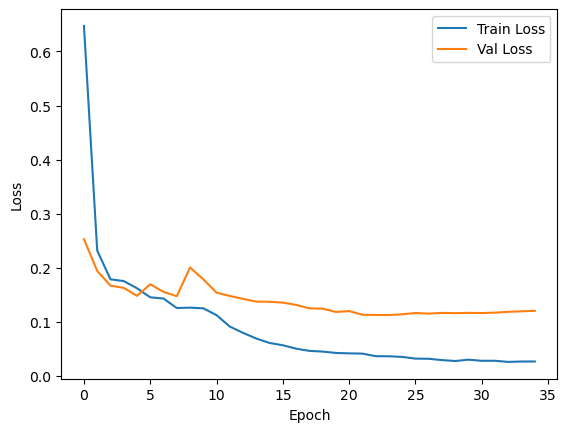

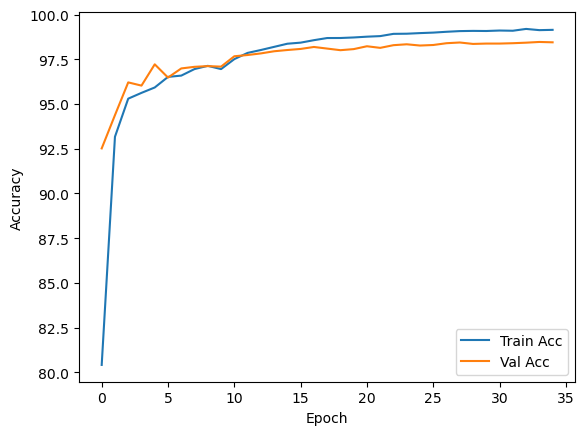

In [119]:
plt.plot(range(0, len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(0, len(val_losses)), val_losses, label='Val Loss')

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.show()

plt.plot(range(0, len(train_accs)), train_accs, label='Train Acc')
plt.plot(range(0, len(val_accs)), val_accs, label='Val Acc')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.legend()
plt.show()